In [2]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import joblib
import numpy as np
from nilearn import plotting
import nibabel as nib

from bold_dementia.connectivity import Atlas
from bold_dementia.connectivity import plot_matrix
from bold_dementia.utils.iterables import unique

import sys
sys.path.append("/homes_unix/jlegrand/MEMENTO")
from utils.visualisation import make_and_show_middle_slices

ATLAS = "schaeffer"
SOFT = False
ALPHA = 0.05

In [3]:
matrices_path = Path(
    f"{config['output_dir']}/connectivity/atlas-{ATLAS}_strategy-high_pass-motion-wm_csf_motion-basic_wm_csf-basic"
)
atlas = Atlas.from_name(ATLAS, soft=SOFT)
coords = atlas.get_coords()

In [4]:
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")
fdrmat = joblib.load(matrices_path / "fdr_mat.joblib")
tstats = joblib.load(matrices_path / "tstats.joblib")


n_AD = AD_matrices.shape[0]
n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

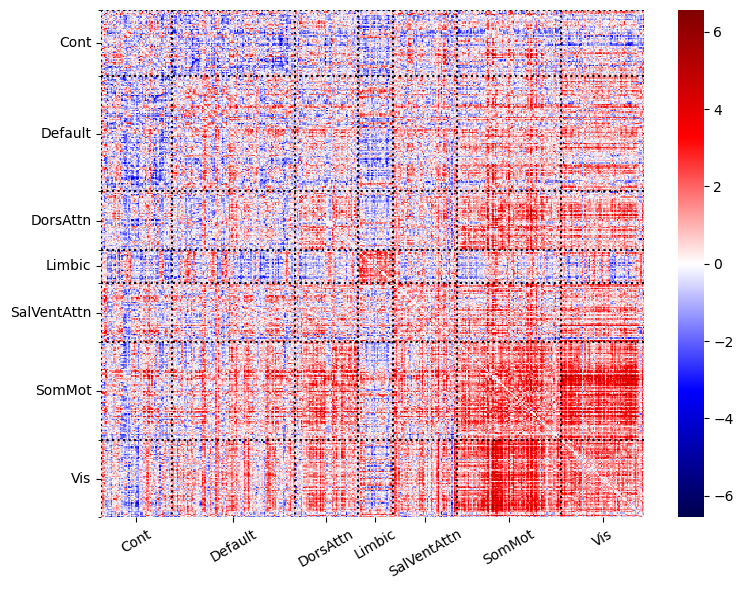

In [5]:
thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
plot_matrix(tstats, atlas)
plt.show()

In [7]:
view = plotting.view_connectome(thresholded_t, coords, edge_threshold="99.9%")
view.open_in_browser()

In [14]:
output_path = Path(config["output_dir"]) / "atlases" / f"{atlas.name}.nii.gz"

network_images = []

networks = np.array(atlas.macro_labels)
maps = nib.load(atlas.maps)
img = maps.get_fdata()

for network in unique(atlas.macro_labels):
    
    network_colors = list(np.where(networks == network)[0])
    
    print(f"{network} : {len(network_colors)} regions")

    network_img = np.where(np.isin(img, network_colors), 2., 1.)
    bg_mask = np.where(img == 0, 0, 1)
    network_images.append(network_img * bg_mask)

output_img = np.stack(network_images, axis=-1)
network_maps = nib.Nifti1Image(output_img, maps.affine)
nib.save(network_maps, output_path)
    

Vis : 61 regions
SomMot : 77 regions
DorsAttn : 46 regions
SalVentAttn : 47 regions
Limbic : 26 regions
Cont : 52 regions
Default : 91 regions
